## Notebook 1: Segmentation of satellite images of water bodies using deep learning models with Keras in TensorFlow

The dataset used in this notebook is a collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water. The masks were created to detect and measure vegetation in satellite images.

In this notebook, I used built-in Keras Sequential model with and without data augmentation technique to perform segmentation of satellite images of water bodies.

**1. Prepare Problem**

In [1]:
# a) Load libraries

from numpy import asarray
import numpy as np

import os
import cv2
import glob
import imagehash
from PIL import Image

import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# b) Load dataset

images = sorted(glob.glob("C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes/*.jpg"))
masks = sorted(glob.glob("C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Masks/all_classes/*.jpg"))

print(len(images), len(masks))

2841 2841


In total, there are 2,841 photos in each Images and Masks folders.

**2. Exploratory Data Analysis**

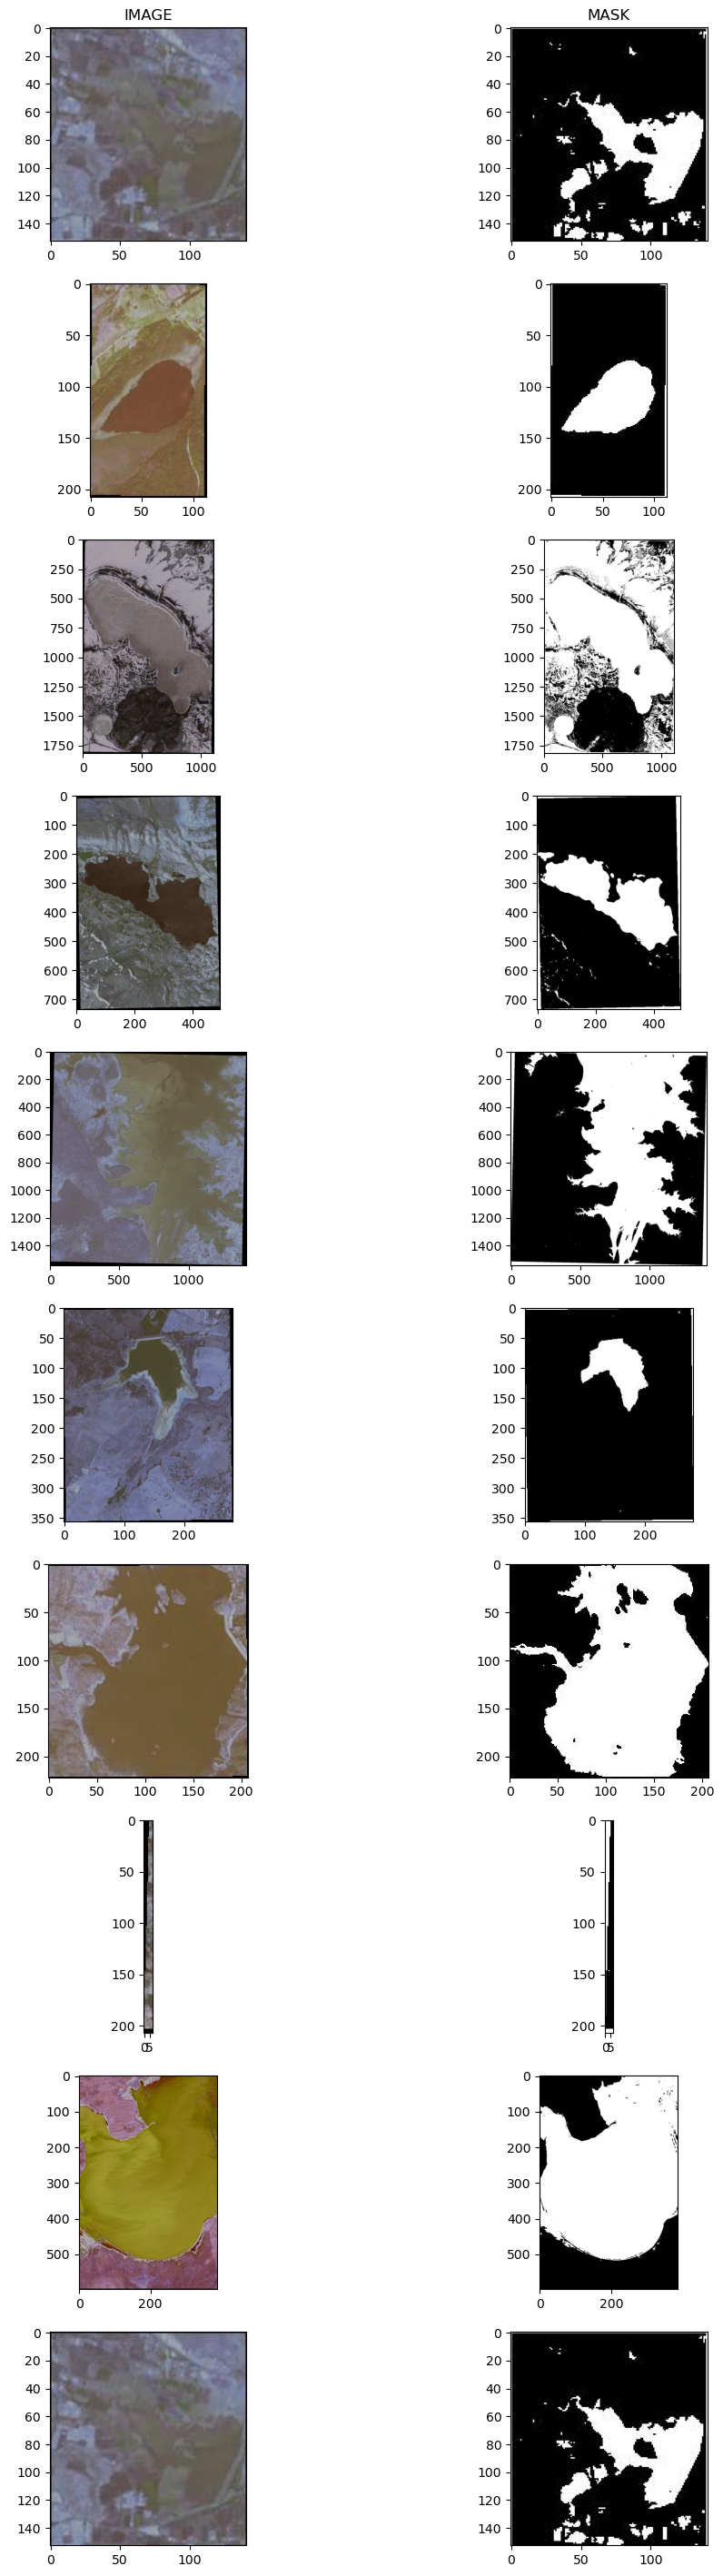

In [3]:
# a) Image visualization
# plot first few random images in Images and Masks folder
f, axr = plt.subplots(10,2, figsize=(12,36))
for i in range(10):
    idx = np.random.randint(0, len(images))
    original = cv2.imread(images[idx])
    mask = cv2.imread(masks[idx])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask)
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

We can see images and masks come with different shapes and even blank masks. These factors may present challenges during the transformation and training processes.

Let's examine the statistical figures of the dataset to understand how the dimensions are distributed among the images. This will help us identify any abnormal size images that can be filtered out to improve training performance.

In [4]:
# Calculate statistics of the image dimensions
dimen_img_list = []

for img in images:
    img = cv2.imread(img, cv2.COLOR_BGR2RGB)
    dimen_img = img.shape[:2]
    dimen_img_list.append(dimen_img)

# Convert the list to numpy array
dimen_img_array = np.array(dimen_img_list)   

In [5]:
# Calculate statistics of the image dimensions
print("Statistics of image dimensions:")
print("Minimum width:", np.min(dimen_img_array[:, 1]))
print("Maximum width:", np.max(dimen_img_array[:, 1]))
print("Mean width:", np.mean(dimen_img_array[:, 1]))
print("Median width:", np.median(dimen_img_array[:, 1]))
print("Standard deviation of width:", np.std(dimen_img_array[:, 1]))
print("Minimum height:", np.min(dimen_img_array[:, 0]))
print("Maximum height:", np.max(dimen_img_array[:, 0]))
print("Mean height:", np.mean(dimen_img_array[:, 0]))
print("Median height:", np.median(dimen_img_array[:, 0]))
print("Standard deviation of height:", np.std(dimen_img_array[:, 0]))

Statistics of image dimensions:
Minimum width: 5
Maximum width: 5640
Mean width: 445.2555438225977
Median width: 259.0
Standard deviation of width: 553.6202774845702
Minimum height: 7
Maximum height: 7093
Mean height: 560.6652587117212
Median height: 334.0
Standard deviation of height: 688.890393959364


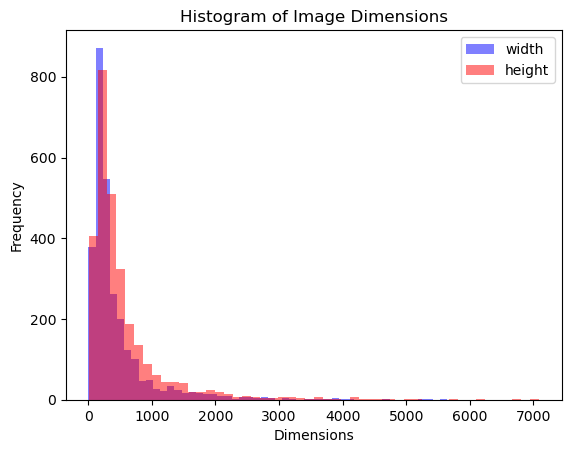

In [6]:
# Plot the histogram
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Histogram of Image Dimensions')
plt.legend()
plt.show()

The statistical result suggests that the median values of height and width of the images are around 300 pixels and therefore, it would be advisable to resize all images and masks to this size or larger to ensure good training performance. To filter out any images with abnormal sizes, a cut-off threshold of 32 pixels (which is 10% of the median value) will be applied.

**3. Prepare Data**

In [7]:
# a) Data Cleaning

#Detect and remove duplicate images and masks
hashes = {}
to_remove = []

for file in images:
    if file.endswith('.jpg'):
        with open(file, 'rb') as f:
            img = Image.open(f)
            # Compute the hash value for the image
            h = imagehash.phash(img)
            # Check if the hash value already exists in the dictionary
            if h in hashes:
                print(f'Duplicate image found: {file} and {hashes[h]}')
                to_remove.append(file)
                mask_file = os.path.join("C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Masks/all_classes", os.path.basename(file))
                to_remove.append(mask_file)
            else:
                hashes[h] = file

Duplicate image found: C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1244.jpg and C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1023.jpg
Duplicate image found: C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1333.jpg and C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1023.jpg
Duplicate image found: C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1552.jpg and C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1023.jpg
Duplicate image found: C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Images/all_classes\water_body_1619.jpg and C:/Users/s

After removing 17 duplicate images and their corresponding masks, new lists of images and masks were created for the next stage of data processing.

In [8]:
# Create a new list of filenames that excludes the duplicates
new_images = [file for file in images if file not in to_remove]
new_masks = [os.path.join("C:/Users/son.tran2/Documents/5_Segmentation_Satellite_Images_Water_Bodies/Water_bodies/Masks/all_classes", os.path.basename(file)) for file in new_images]
print(len(new_images), len(new_masks))

2824 2824


In [9]:
# Load, filter blank and abnormal size images and masks, and resize them to the median values or larger

min_size = 32
df_images = []
df_masks = []

height = width = 300

for image, mask in zip(new_images, new_masks):
    #cv2.imread reads image in BGR, we need to convert it back to the standard mode RGB 
    n = cv2.imread(image, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image has size > min_size and is entirely black or white 
    if min(n.shape[:2]) > min_size and ((m != 0).any() and (m != 255).any()):
        n = cv2.resize(n, (height, width)) # resize to median values or larger 
        df_images.append(n)
        m = cv2.resize(m, (height, width)) # resize to median values or larger
        df_masks.append(m)

# Convert image into array of pixels
df_images = asarray(df_images)

# Convert mask into array of pixels
df_masks = asarray(df_masks)

print(len(df_images), len(df_masks))

2698 2698


In total, 126 images and their corresponding masks were removed from the dataset, leaving a total of 2698 samples for training, testing, and validation.

In [10]:
# b) Split data into train and test sets

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.015, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(2023, 300, 300, 3) (2023, 300, 300) (664, 300, 300, 3) (664, 300, 300) (11, 300, 300, 3) (11, 300, 300)


In [11]:
# Flatten images and convert data from numpy array to float type
X_train = X_train.reshape(X_train.shape[0], height, width, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], height, width, 3).astype('float32')
X_val = X_val.reshape(X_val.shape[0], height, width, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0], height, width).astype('float32')
y_test = y_test.reshape(y_test.shape[0], height, width).astype('float32')
y_val = y_val.reshape(y_val.shape[0], height, width).astype('float32')

In [12]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
y_train = y_train / 255
y_test = y_test / 255
y_val = y_val / 255

In [13]:
print(X_train.shape, X_test.shape)

(2023, 300, 300, 3) (664, 300, 300, 3)


**4. Evaluate Models**

To perform image segmentation, one common approach is to use a Fully Convolutional Network (FCN) architecture, which consists of convolutional layers and upsampling layers to transform the input image into a segmentation map.

- The encoding layers are typically composed of convolutional and pooling layers, which are used to extract high-level features from the input image while reducing its spatial resolution. The convolutional layers are responsible for detecting local features such as edges, corners, and blobs, while the pooling layers reduce the spatial resolution of the feature maps to make the network more efficient.

- The decoding layers, on the other hand, use upsampling and convolutional layers to transform the low-resolution feature maps produced by the encoding layers into a high-resolution segmentation map. The upsampling layers are used to increase the spatial resolution of the feature maps, while the convolutional layers are used to refine the segmentation map and produce the final output.

The FCN architecture combines the encoding and decoding layers to create an end-to-end segmentation network that can produce pixel-wise segmentation masks for an input image.

In [14]:
input_shape = (height, width, 3)

def base_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoding layers
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding layers
    up3 = layers.UpSampling2D(size=(2, 2))(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(up5)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model
model = base_model(input_shape)

# Reshape target data to match output shape of the model
y_train = y_train.reshape(-1, height, width, 1)
y_test = y_test.reshape(-1, height, width, 1)

In [15]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [16]:
# Fit the model to train and test sets
history = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
32/32 [==============================] - 305s 10s/step - loss: 0.5475 - accuracy: 0.6021 - val_loss: 0.4856 - val_accuracy: 0.6591
Epoch 2/30
32/32 [==============================] - 292s 9s/step - loss: 0.4783 - accuracy: 0.6545 - val_loss: 0.4945 - val_accuracy: 0.6504
Epoch 3/30
32/32 [==============================] - 292s 9s/step - loss: 0.4568 - accuracy: 0.6635 - val_loss: 0.4642 - val_accuracy: 0.6627
Epoch 4/30
32/32 [==============================] - 297s 9s/step - loss: 0.4316 - accuracy: 0.6790 - val_loss: 0.4032 - val_accuracy: 0.6974
Epoch 5/30
32/32 [==============================] - 309s 10s/step - loss: 0.4149 - accuracy: 0.6846 - val_loss: 0.4101 - val_accuracy: 0.6838
Epoch 6/30
32/32 [==============================] - 305s 10s/step - loss: 0.4096 - accuracy: 0.6878 - val_loss: 0.3871 - val_accuracy: 0.6953
Epoch 7/30
32/32 [==============================] - 300s 9s/step - loss: 0.3838 - accuracy: 0.7001 - val_loss: 0.4510 - val_accuracy: 0.6575
Epoch 8/30

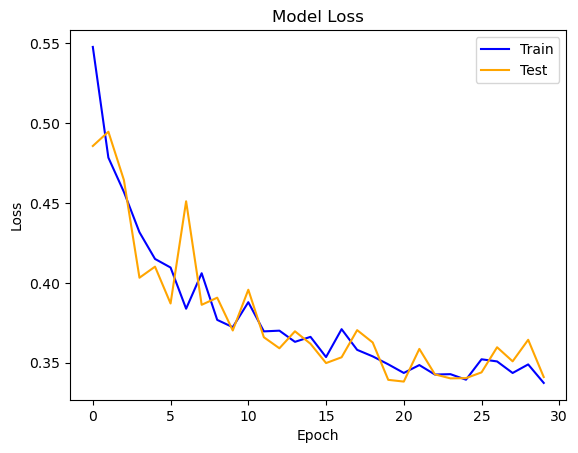

In [17]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

The loss values of training and validation are in good agreement and are reasonable for a simple FCN model.

**4. Improved Baseline Models**

In this section, we aims at improving the baseline model by applying image augmentation to the dataset.

In [18]:
# Create a generator that performs simple augmentation on the baseline image, 
# specifically horizontal flips and 10% shifts in the height and width of the images in train and test sets.

gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [19]:
# Prepare iterators for each dataset
train_gen = gen.flow(X_train, y_train, batch_size=64)
test_gen = gen.flow(X_test, y_test, batch_size=64)

In [20]:
# Use the same FCN architecture as the baseline model
model2 = base_model(input_shape)

In [21]:
# Fit the model
history2 = model2.fit(train_gen, epochs=30, batch_size=64, validation_data=test_gen, callbacks=[early_stopping])

Epoch 1/30
32/32 [==============================] - 302s 9s/step - loss: 0.5973 - accuracy: 0.5805 - val_loss: 0.5496 - val_accuracy: 0.5884
Epoch 2/30
32/32 [==============================] - 307s 10s/step - loss: 0.5500 - accuracy: 0.6077 - val_loss: 0.5489 - val_accuracy: 0.6123
Epoch 3/30
32/32 [==============================] - 301s 9s/step - loss: 0.5417 - accuracy: 0.6169 - val_loss: 0.5352 - val_accuracy: 0.6288
Epoch 4/30
32/32 [==============================] - 295s 9s/step - loss: 0.5467 - accuracy: 0.6123 - val_loss: 0.5374 - val_accuracy: 0.6315
Epoch 5/30
32/32 [==============================] - 299s 9s/step - loss: 0.5421 - accuracy: 0.6133 - val_loss: 0.5455 - val_accuracy: 0.6068
Epoch 6/30
32/32 [==============================] - 296s 9s/step - loss: 0.5389 - accuracy: 0.6230 - val_loss: 0.5350 - val_accuracy: 0.6184
Epoch 7/30
32/32 [==============================] - 304s 10s/step - loss: 0.5286 - accuracy: 0.6316 - val_loss: 0.5227 - val_accuracy: 0.6409
Epoch 8/30


We can see that contrary to what we would have hoped of a further lift in model performance, the new model performs worse than the baseline one. 

Using both dropout regularization and data augmentation techniques together hasn't improved model's performance which can be explained by (1) the size and complexity of the dataset, and (2) possibly some extent of overfitting from the data augmentation.

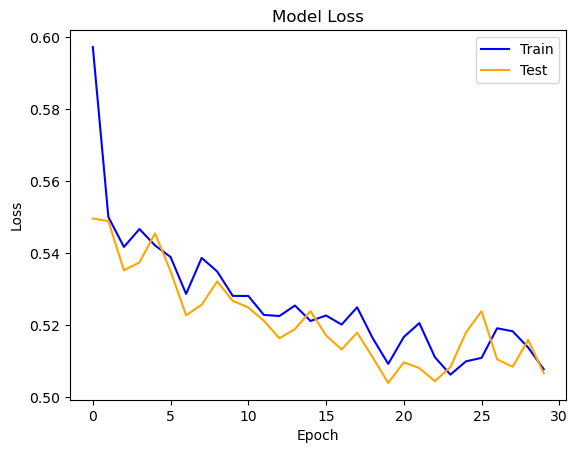

In [22]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history2.history['loss'], color='blue', label='train')
plt.plot(history2.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

Since the new model underperforms the baseline one, we will use the baseline model for prediction and finalization.

**5. Finalize Model**

1/1 [==============================] - 1s 590ms/step


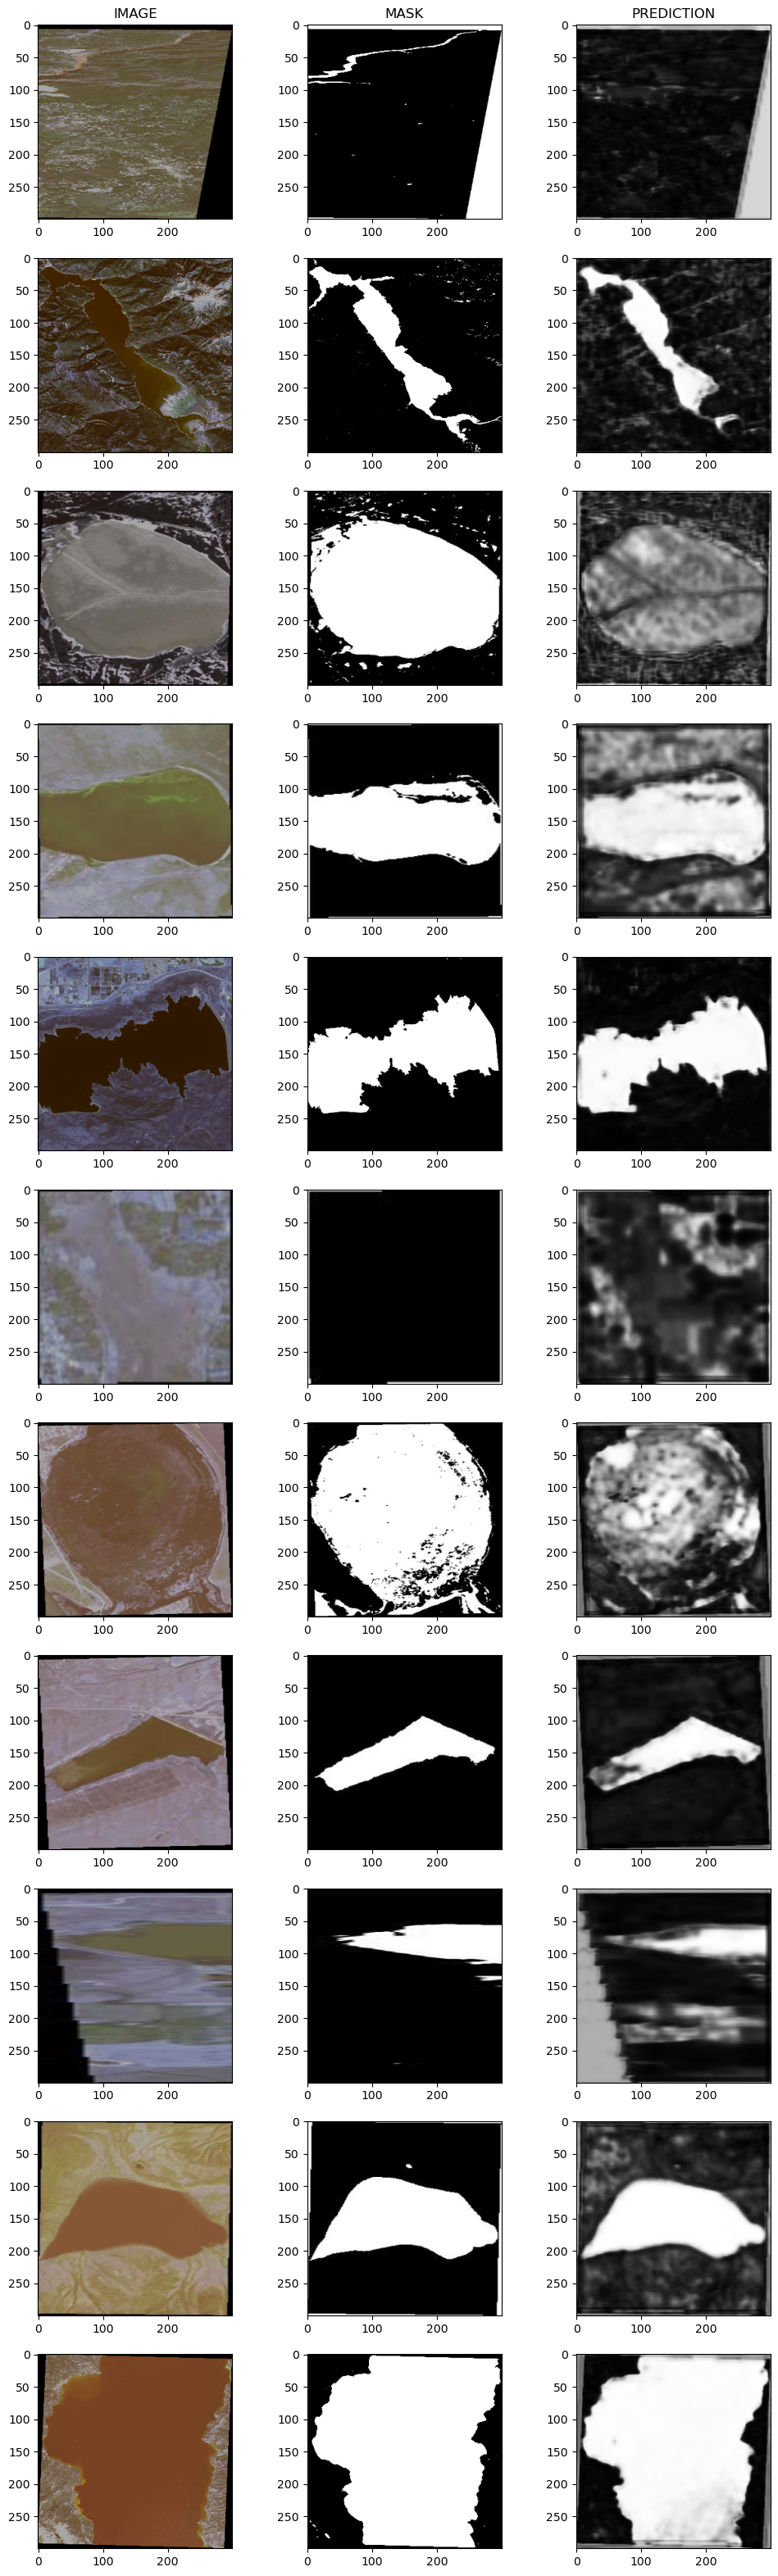

In [23]:
# a) Predictions on validation data
Pred = model.predict(X_val)

# Plot original and predicted images
fig, ax = plt.subplots(11, 3, figsize=(12,40))
for i in range(11):
    orig = X_val[i]
    msk = y_val[i]
    pred = Pred[i]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk, cmap='gray')
    ax[i,2].imshow(pred, cmap='gray')
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

Overall, the predicted images capture mostly large and clear-shaped water bodies. However, further improvement by using a larger and pre-trained model might allow the model to predict features with relatively small and irregular shapes.

In [24]:
# b) Save the model for later use

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_transpose
......vars
.........0
.........1
...layers\input_layer
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\up_sampling2d
......vars
...layers\up_sampling2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             S

**6. Conclusions**

- Data cleaning is essential to remove duplicate, blank, and abnormal size images before passing into the neural network model for segmentation.

- Satellite image introduce additional challenges, such as different sizes, resolutions, and details of objects to be detected, compared to common images.

- A Fully Convolutional Network architecture, which consists of convolutional layers and upsampling layers to produce a segmentation mask, can accurately detect and reproduce the shape of most water bodies in the image and mask dataset, evidenced by reasonable validation loss and accuracy. 

- The use of dropout regularization and data augmentation doesn't improve the performance of the model owing to the size and complexity of the dataset, and possibly some extent of overfitting from the data augmentation.

- The model performance might be improved by using large and pre-trained models (such as ResNet-50) and will be covered in the second Notebook of this repository.